In [2]:
import lang2vec.lang2vec as l2v
import umap
import umap.plot
import numpy as np
import matplotlib.pyplot as plt

from language_utils.utils import fam
from languages import Node, Language

languages = list(l2v.available_uriel_languages())
families = [
    family[2:]
    for family
    in l2v.get_features('en', 'fam', header=True)['CODE']
]
isos = dict(
    line.strip().split(' ', maxsplit=1)
    for line
    in open('iso.txt', encoding='utf-8')
)

In [3]:
lang_fams = {l: set() for l in languages}
data = l2v.get_features(languages, 'fam')
for lang, vec in data.items():
    for val, fam in zip(vec, families):
        if val:
            lang_fams[lang].add(fam)


In [4]:
data = np.vstack([
    vec
    for vec
    in l2v.get_features(
        languages=languages,
        feature_set_inp='syntax_knn+phonology_knn+inventory_knn',
    ).values()
])

reducer = umap.UMAP(n_neighbors=15, metric='cosine', min_dist=0.5)
trans = reducer.fit(data)

In [5]:
coi = [
    'Atlantic-Congo',
    'Austronesian',
    'Indo-European',
    'Afro-Asiatic',
    'Sino-Tibetan',
    'Nuclear_Trans_New_Guinea',
    'Pama-Nyungan',
    'Otomanguean',
    'Austroasiatic',
    'Semitic',
    'Dravidian',
    'Turkic',
    'Slavic',
    'Germanic',
    'Italic'
]
coi_set = set(coi)

dd = {
    f: sum(
        f in lang_fams[l]
        for l
        in languages
        if not lang_fams[l].intersection(coi_set)
    )
    for f
    in families
}

# for k in sorted(dd, key=lambda x: -dd[x]):
#     print(k, dd[k])
    
coi_l = {l: i+1 for i, l in enumerate(coi)}

labels = [
    max(
        [coi_l.get(c, 0)
        for c
        in lang_fams[l]] + [0]
    )
    for l
    in languages
]

<AxesSubplot:>

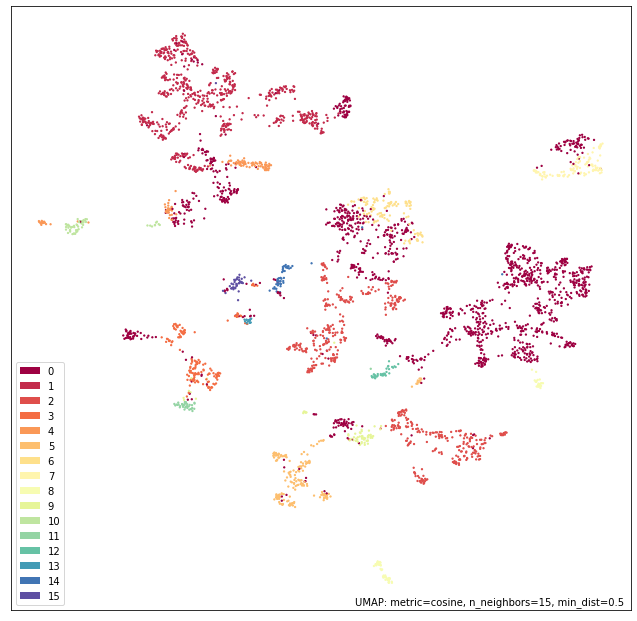

In [6]:
umap.plot.points(
    trans,
    labels=np.array(labels)
)

In [7]:
trans.embedding_

array([[  7.5777817,  -8.270853 ],
       [  5.6523004,  -7.356067 ],
       [ -3.2672293,  11.86411  ],
       ...,
       [ -0.7831883, -11.600383 ],
       [  5.612629 ,  -2.8719358],
       [  7.8070817,  -1.3133646]], dtype=float32)

In [8]:
print(coi_l)

{'Atlantic-Congo': 1, 'Austronesian': 2, 'Indo-European': 3, 'Afro-Asiatic': 4, 'Sino-Tibetan': 5, 'Nuclear_Trans_New_Guinea': 6, 'Pama-Nyungan': 7, 'Otomanguean': 8, 'Austroasiatic': 9, 'Semitic': 10, 'Dravidian': 11, 'Turkic': 12, 'Slavic': 13, 'Germanic': 14, 'Italic': 15}


/root/miniconda3/lib/python3.8/site-packages/umap/plot.py:849: UserWarning: Hammer edge bundling is expensive for large graphs!
This may take a long time to compute!
  warn(


<AxesSubplot:>

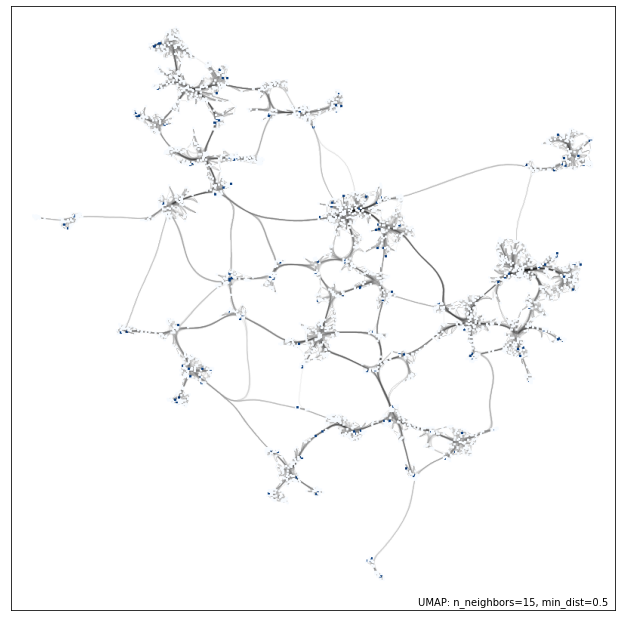

In [9]:
umap.plot.connectivity(trans, show_points=True, edge_bundling='hammer')

In [10]:
ner_langs = [
    l2v.LETTER_CODES[line.split()[0]]
    for line
    in open('./papers/rahimi_ner.txt')
]

help(umap.plot.interactive)

Help on function interactive in module umap.plot:

interactive(umap_object, labels=None, values=None, hover_data=None, theme=None, cmap='Blues', color_key=None, color_key_cmap='Spectral', background='white', width=800, height=800, point_size=None, subset_points=None, interactive_text_search=False, interactive_text_search_columns=None, interactive_text_search_alpha_contrast=0.95)
    Create an interactive bokeh plot of a UMAP embedding.
    While static plots are useful, sometimes a plot that
    supports interactive zooming, and hover tooltips for
    individual points is much more desireable. This function
    provides a simple interface for creating such plots. The
    result is a bokeh plot that will be displayed in a notebook.
    
    Note that more complex tooltips etc. will require custom
    code -- this is merely meant to provide fast and easy
    access to interactive plotting.
    
    Parameters
    ----------
    umap_object: trained UMAP object
        A trained UMAP obje

In [11]:
from bokeh.plotting import show, save, output_notebook, output_file
import pandas as pd

hover_data = pd.DataFrame({
    'c': labels,
    'fam': [' '.join(lang_fams[lang]) for lang in languages],
    'code': languages,
    'lang': [isos.get(lang, lang) for lang in languages],
    'dataset': ['ner41' if lang in ner_langs else '' for lang in languages],
})

p = umap.plot.interactive(
    trans,
    labels=labels,
    hover_data=hover_data,
    width=600,
    height=600,
    interactive_text_search=True,
    point_size=4,
    interactive_text_search_alpha_contrast=0.99,
    background='black'
)
output_notebook()
show(p)

Loading BokehJS ...